# Dual blocker therapy (DBT) plasma proteome Paper — Figure 1

This Jupyter Notebook (with Python 3 kernel) contained the code for the proteomic analysis of DBT cohort design, quality control, data distribution, and biological processes description.

Input files:  
* The clinical file: category.csv
* The DBT proteome file: dbt.csv
* The quality control samples proteome file: qc_repeat.csv

Output figures:  
* Figure 1C, S1A, S1B, S2A, S2B, S2C

In [24]:
from utils import *
paths = ['../figure/figure1', '../documents/figure1']
for path in paths:
    if not os.path.isdir(path):
        os.makedirs(path)

a = Analysis('../')

### Cohort design

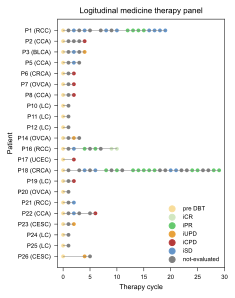

In [2]:
tmp = a.category[['Response state iRECIST', 'Patient ID', 'Therapy ID']].dropna()
tmp['order_'] = tmp['Therapy ID'].replace('pre DBT', '0').str.extract('(\d+)').astype(int)
order_sample = ['P'+str(i) for i in range(1, 27, 1)]

mapping_ = a.category[['Patient ID', 'Tumor type']].drop_duplicates().dropna().set_index('Patient ID').to_dict()['Tumor type']

plotdata = tmp.drop('Therapy ID', axis=1).iloc[:, [2, 0, 1]]
plotdata['patient_order'] = plotdata['Patient ID'].str[1:].astype(int)
plotdata = plotdata.sort_values('patient_order').drop('patient_order', axis=1)
plotdata['Patient ID'] = plotdata['Patient ID'].map(lambda x: x+' ('+mapping_[x]+')')
ax = bubbleplot(plotdata, palette=a._color_map['Response state iRECIST'], figsize=(3, 4.5), s=15)
ax.set_xlim([-1, 30])

n = plotdata['Patient ID'].nunique()
plotdata_line = plotdata.groupby(['Patient ID'], sort=False).apply(lambda x: x.loc[:, 'order_'].sort_values().iloc[[0, -1]]).droplevel(1).reset_index().iloc[:, [1, 0]].assign(y=np.repeat(np.arange(n), 2))
ax = lineplot(plotdata_line, palette=['grey']*n, ax=ax, ticklabels_format=[], ticklabels_hide=[], spines_hide=[], legend=False)
ax.set_xlabel('Therapy cycle')
ax.set_ylabel('Patient')
ax.set_title('Logitudinal medicine therapy panel')

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, -1, 2, -2, -3, 1, 3]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='best', frameon=False)
ax.get_figure().savefig('../figure/figure1/Fig1C_cohort_design_panel.pdf', bbox_inches='tight')

### Repeated samples

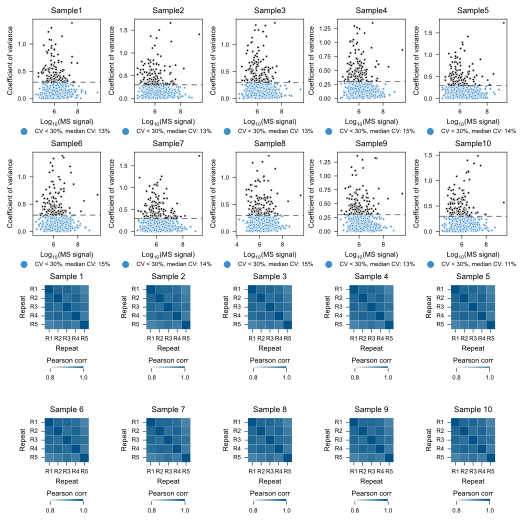

In [3]:
s = ''
a._data['repeat_qc'] = a._data['repeat_qc'].replace(0, np.nan)
a._data['repeat_qc'].columns = a._data['repeat_qc'].columns.map(lambda x: x.split('.')[0])
a._data['repeat_qc'].columns.name = 'sample'
cv = pd.DataFrame()
for sample in a.repeat_qc.columns.unique():
    tmp_df = a.repeat_qc[sample]
    cv = pd.concat([cv, (tmp_df.std(axis=1)/tmp_df.mean(axis=1)).rename(sample)], axis=1)
cv = cv.dropna(how='all').rename_axis('protein').rename_axis('Sample', axis=1)

fig, axes = plt.subplot_mosaic("ABCDE;FGHIJ;KLMNO;PQRST", figsize=(8.5, 8.7))
plt.subplots_adjust(hspace=.6, wspace=.5)

for sample, pos in zip(a.repeat_qc.columns.unique(), 'ABCDEFGHIJ'):
    tmp = pd.concat([a.repeat_qc[sample].mean(axis=1).pipe(np.log10).rename('$\mathregular{Log_{10}}$(MS signal)'), cv[sample].rename('Coefficient of variance')], axis=1).dropna()
    tmp.loc[tmp['Coefficient of variance']<.3, ' '] = 'CV < 30%, median CV: {:.0%}'.format(tmp['Coefficient of variance'].median())
    tmp.loc[:, ' '] = tmp.loc[:, ' '].fillna('')
    scatterplot(tmp.iloc[:, [0, 2, 1]], linewidth=.5, palette=['#3D8ECD', 'black'], s=5, edgecolor=['white', 'white'], ticklabels_format=[], ticklabels_hide=[], ax=axes[pos], title=sample, spines_hide=[])
    axes[pos].axhline(y=.3, c="black", ls="--", dashes=(11, 8), lw=0.5)
    axes[pos].legend(loc="lower center", bbox_to_anchor=(0.46, -.45), frameon=False)

for sample, pos in zip(a.repeat_qc.columns.unique(), 'KLMNOPQRST'):
    out = {}
    a._data['repeat_qc'].columns = a._data['repeat_qc'].columns.map(lambda x: x.split('.')[0])
    a._data['tmp'] = a.repeat_qc.loc[:, 'Sample1'].T.pipe(np.log10)
    a._data['tmp'].index = [x + '_' + str(i) for i, x in enumerate(a.tmp.index, start=1)]
    for i in a.tmp.index:
        a.set_param('corr', name1='tmp', name2='tmp', element1=i, element2='all', file_type=None)
        out[i] = a.corr_table.loc[:, 'pearson_corr'].to_dict()
    corr_df = pd.DataFrame().from_dict(out).rename(columns=lambda x: x.replace('Sample1_', 'R')).rename(index=lambda x: x.replace('Sample1_', 'R'))
    ax = heatmap(corr_df, square=True, vmax=1, vmin=.8, center=.9, cmap=B_CMAP, xticklabels=True, cbar_kws={'orientation': 'horizontal', 'fraction': .02, 'pad': .45}, ax=axes[pos])
    ax.set_xlabel('Repeat')
    ax.set_ylabel('Repeat')
    ax.set_title(sample.replace('Sample', 'Sample '))
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.collections[0].colorbar.set_label("Pearson corr", rotation=0, labelpad=-23, y=1.2)
    ts = '{:.2f}-{:.2f}'.format(corr_df.replace(1, np.nan).stack().min(), corr_df.replace(1, np.nan).stack().max())
    s = ', '.join([s, ts])
    
fig.savefig('../figure/figure1/FigS1A-B_sample_repeat_quality_control_CV_plots.pdf', bbox_inches='tight')

### Proteome data sample-wise distribution

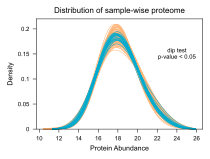

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
data = a.dbt.rename_axis('Sample', axis=1).unstack().dropna().rename('Protein Abundance')
for cohort in a.category.Cohort.unique():
    sample = a.category.query("Cohort==@cohort").index
    plotdata = data.loc[sample].reset_index()
    sns.kdeplot(data=plotdata, x='Protein Abundance', hue='Sample', common_norm=False, common_grid=True, ax=ax, legend=False, palette=[a._color_map['Cohort'][cohort]]*plotdata['Sample'].nunique(), bw_adjust=2)
dip = data.groupby('Sample').apply(lambda x: r_func('dip', x.values.tolist())).explode().sort_values()
if dip.max() < 0.05:
    ax.text(24, 0.15, 'dip test\np-value < 0.05', ha='center', va='center')
ax.set_title('Distribution of sample-wise proteome', fontsize=8)
ax.set_yticks([0, 0.05, 0.10, 0.15, 0.2])
ax.set_yticklabels([0, 0.05, 0.10, 0.15, 0.2])
ax.get_figure().savefig('../figure/figure1/FigS2A_proteome_sample_distribution_plot.pdf', bbox_inches='tight')

### Batch effects of the dataset

'brinfo: 7.00%'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


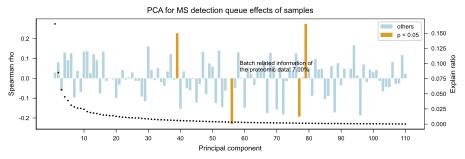

In [8]:
from utils.algorithm import core_PCA
from sklearn.preprocessing import StandardScaler

queue = a.continuous.loc['queue'].dropna()
data = a.dbt

sample = np.intersect1d(data.columns, queue.index)
pca, var = core_PCA(StandardScaler().fit_transform(data[sample].fillna(0).T))

out = {}
for i in range(pca.shape[1]):
    out[i] = scipy.stats.spearmanr(pca[:, i], queue)

out_df = pd.DataFrame().from_dict(out, orient='index').assign(ev=var)
queue_information = np.sum(out_df.iloc[:, 0].abs() * out_df.ev)
display('brinfo: {:.2%}'.format(queue_information))

df = out_df.rename_axis('Principal component').rename(index=lambda x: x+1).reset_index()
df.loc[(df['pvalue']<.05), 'annot'] = 'p < 0.05'
df.loc[:, 'annot'] = df.loc[:, 'annot'].fillna('others')
df.to_csv('../documents/figure1/batch_effects_evaluation_table.csv')

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax_twin = ax.twinx()
barplot(df.iloc[:, [0, -1, 1]].sort_values('annot'), ax=ax, ticklabels_format=[], ticklabels_hide=[], palette=['lightblue', 'orange'])
ax.set_xticks(range(9, len(data), 10))
ax.set_xticklabels(range(10, len(data), 10))
ax.set_ylabel('Spearman rho')
ax.legend(loc='upper right')

plotdata = df.iloc[:, [0, 3]]
plotdata.iloc[:, 0] = plotdata.iloc[:, 0] - 1
ax_twin = scatterplot(plotdata, ax=ax_twin, color='black', s=3, ticklabels_format=[], ticklabels_hide=[], spines_hide=[], title='PCA for MS detection queue effects of samples')
ax_twin.set_ylabel('Explain ratio')
ax_twin.text(x=ax_twin.get_xlim()[1]*0.5, y=ax_twin.get_ylim()[1]*0.5, s='Batch related information of\nthe proteomic data: {:.2%}'.format(queue_information))
fig.savefig('../figure/figure1/FigS2B_batch_effects_plot.pdf', bbox_inches='tight')

### Dynamic range and ORA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


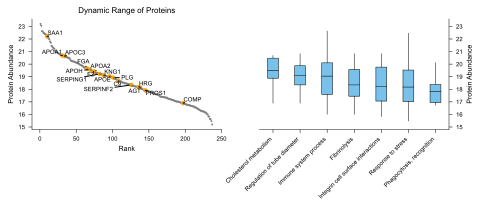

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(7.5, 2))
plt.subplots_adjust(wspace=.2)

a._data['category'] = a.category.rename(columns={'Cohort': 'cohort'})
a._data['tmp'] = 10 ** a.dbt
a.set_param('group', dataset_type='tmp', group_name='cohort', part_element=['DBT'])
ax = a.range(size=2, title='Dynamic Range of Proteins', legend=False, highlight_annots={'highlight': [['F2', 'APOE', 'APOH', 'APOA2', 'SERPINF2', 'SAA1', 'C9', 'KNG1', 'APOC3', 'HRG', 'FGA', 'AGT', 'PROS1', 'APOA1', 'PLG', 'COMP', 'SERPING1'], 'orange', 10]}, sizes=(4, 20), ticklabels_format=[], ticklabels_hide=[], ax=axs[0])
ax.set_xticks([0, 50, 100, 150, 200, 250])
ax.set_xticklabels([0, 50, 100, 150, 200, 250])
ax.set_ylabel('Protein Abundance')
ax.set_xlabel('Rank')
ylim = ax.get_ylim()

plotdata = pd.DataFrame(a._Group__param_values['mean'].T, columns=a._group_values, index=a._tmp_dataset.index).stack().astype('float32').rename_axis(['Symbol', a._group_name]).groupby(a._group_name).apply(lambda x: x.sort_values(ascending=False).rename('value').reset_index()).droplevel(0).set_index('Symbol', append=True).droplevel(0).dropna()
o = ora('gprofiler')
out = o.run(plotdata.index.tolist(), db=['reac', 'kegg', 'gobp'])

from utils.function import sort_custom
term = ['immune system process', 'Cholesterol metabolism', 'Integrin cell surface interactions', 'response to stress', 'phagocytosis, recognition', 'regulation of tube diameter', 'fibrinolysis']
tmp = pd.merge(out.query("name in @term").set_index('name')['intersections'].explode().reset_index().set_index('intersections'), plotdata.drop('cohort', axis=1), left_index=True, right_index=True, how='inner').rename_axis('Protein')
order_ = tmp.groupby('name')['value'].median().sort_values(ascending=False).index
tmp = sort_custom(tmp, order_, 'name')
tmp['value'] = np.log10(tmp['value'])
tmp['name'] = tmp['name'].str.capitalize()

box_props = {'boxprops': {'facecolor': '#78C1EB', 'edgecolor': 'k'},'medianprops': {'color': 'k'}, 'whiskerprops': {'color': 'k'}, 'capprops': {'linewidth': 0}}
ax = sns.boxplot(data=tmp, x='name', y='value', showfliers=False, width=.4, ax=axs[1], **box_props)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('Protein Abundance')
ax.set_xlabel('')
ax.set_ylim(ylim)
for side in ['top', 'left']:
    ax.spines[side].set_visible(False)

a._data['category'] = a.category.rename(columns={'cohort': 'Cohort'})

fig.savefig('../figure/figure1/FigS2C_dynamic_range_ORA_plot.pdf', bbox_inches='tight')
out.to_csv('../documents/figure1/dynamic_range_ORA_table.csv')